In [8]:
# import re
import math
# import datetime
# from os import path
from PIL import Image

# Data Structures
import numpy as np
import pandas as pd

# Statistics and Processing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Natural Language Processing
import nltk
from nltk.corpus import stopwords

# Visualization
import seaborn as sns
from wordcloud import WordCloud

In [56]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

#Make matplotlib pretty
matplotlib.rcParams.update({'figure.figsize': (15, 9)})
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({'font.family': 'Helvetica, Arial, sans-serif'})

%config InlineBackend.figure_format = 'retina'

In [9]:
# Dataset: Amazon Fine Food Reviews
# [URL] https://www.kaggle.com/snap/amazon-fine-food-reviews
df = pd.read_csv('data/Reviews.csv')
dfs = df.sample(frac=.5)

In [10]:
# Rating function for a review. Biased towards reviews with more total views. 
#
# e.g. 1 positive view out of 1 total view will not rate as high as 
# 1000 positive views out of 1200 total views.
#
# [CITE] https://www.evanmiller.org/how-not-to-sort-by-average-rating.html
# "The lower bound of Wilson score confidence interval for a Bernoulli parameter"
def lbc(positive_votes, total_votes):
    negative_votes = total_votes - positive_votes
    if total_votes == 0:
        return 0.0
    lower_bound = ((positive_votes + 1.9208) / (total_votes) - 1.96 * math.sqrt((total_votes * negative_votes) / (total_votes) + 0.9604) / 
        (total_votes)) / (1 + 3.8416 / (total_votes))
    return lower_bound

In [11]:
try:
    del dfs['ProfileName']
except KeyError:
    print('No such column')

In [12]:
null_value_counts_by_column = dfs.isnull().sum().sort_values(ascending=False)
null_value_counts_by_column

Summary                   11
Text                       0
Time                       0
Score                      0
HelpfulnessDenominator     0
HelpfulnessNumerator       0
UserId                     0
ProductId                  0
Id                         0
dtype: int64

In [13]:
#Remove rows where numerator > denominator. Assume this is entry error in dataset
faulty_rows = dfs[dfs['HelpfulnessNumerator'] > dfs['HelpfulnessDenominator']]
dfs = dfs[dfs['HelpfulnessNumerator'] <= dfs['HelpfulnessDenominator']]

faulty_rows

,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text


In [14]:
# Create Lbc column associated with a review that contains the lbc value for that row
lbc_for_row = lambda row: lbc(row['HelpfulnessNumerator'], row['HelpfulnessDenominator'])
dfs['Lbc'] = dfs.apply(lbc_for_row, axis=1)

# Create Timestamp column associated with a review
dfs['Timestamp'] = pd.to_datetime(dfs['Time'], unit='s')

dfs['ReviewLength'] = dfs['Text'].str.len()

In [29]:
# Creates the bag of words array
# [CITE] https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words
vectorizer = CountVectorizer(
    lowercase = True,
    stop_words = 'english',
    max_features = 1000
)

# A bag of words, where columns are words, rows are reviews,
# and cell values are the number of occurrences of said word
# in said article.
bag_of_words = vectorizer.fit_transform(dfs['Text']).toarray()
df_bag_of_words = pd.DataFrame(bag_of_words, columns=vectorizer.vocabulary_.keys(), dtype='int16')

In [50]:
# Accumulate the sum of each of the columns into 
total_word_frequency = df_bag_of_words.sum(axis=0).sort_values(ascending=False)

In [34]:
# Creates the vector of Tf-Idf for each word in the review
# [CITE] https://stackoverflow.com/a/37593408
tf_idf_vectorizer = TfidfVectorizer(
    lowercase = True, 
    stop_words = 'english',
    max_features = 1000
)

tf_idf = tf_idf_vectorizer.fit_transform(dfs['Text']).toarray()
df_tf_idf = pd.DataFrame(tf_idf, columns=tf_idf_vectorizer.vocabulary_.keys(), dtype='float32')

In [43]:
def lbc_split_by_score(d):
    return [d[d.Score == x].Lbc for x in range(1,6)]

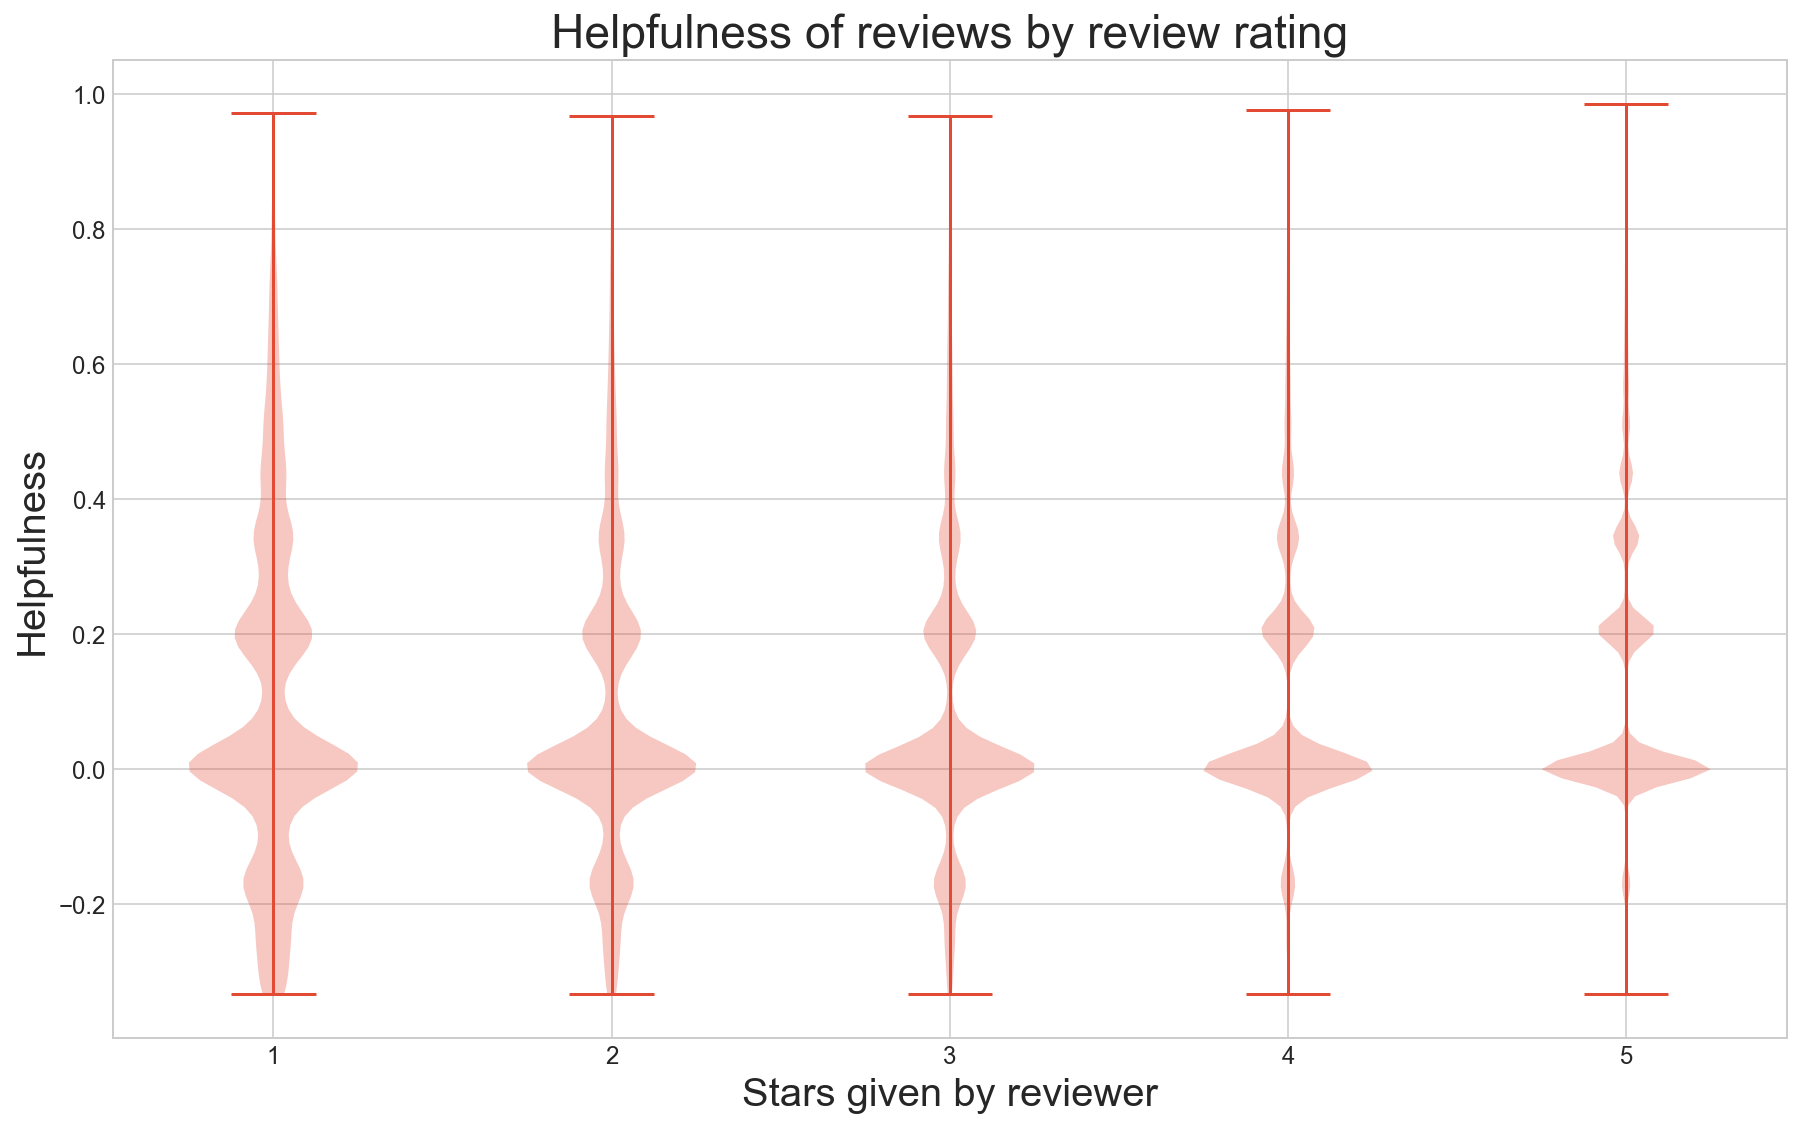

In [57]:
# Graph included entries with zero votes
# [CITE] https://stackoverflow.com/a/43346806/3592716
sns.set_style('whitegrid')
fig, axes = plt.subplots()
axes.violinplot(dataset=lbc_split_by_score(dfs))
axes.set_title('Helpfulness of reviews by review rating')
axes.set_ylabel('Helpfulness')
axes.set_xlabel('Stars given by reviewer')
plt.show()

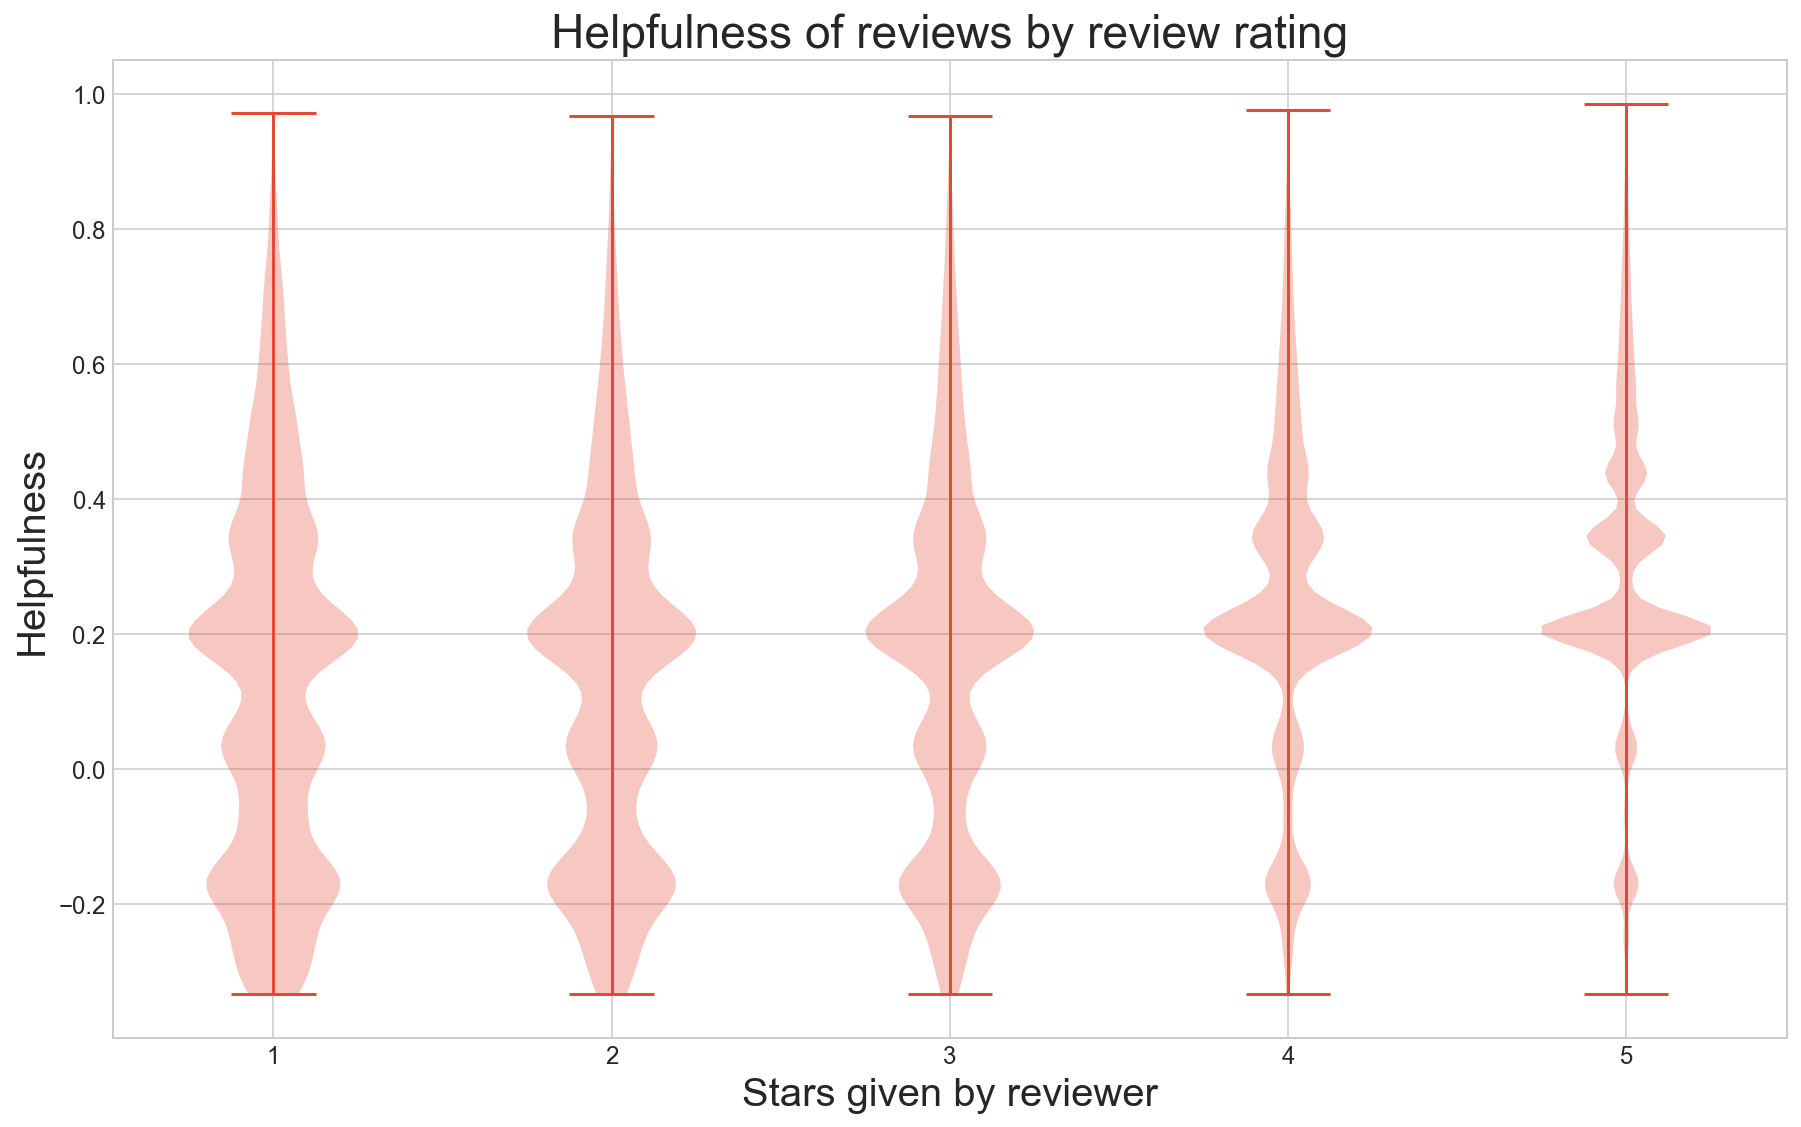

In [58]:
#As the rating the author goes up, the usefulness of the comment get better

# Graph containing only entries that have atleast 1 vote
dfs_without_zero_helpfulness = dfs[dfs['HelpfulnessDenominator'] != 0]

sns.set_style('whitegrid')
fig, axes = plt.subplots()
axes.violinplot(dataset=lbc_split_by_score(dfs_without_zero_helpfulness))
axes.set_title('Helpfulness of reviews by review rating')
axes.set_ylabel('Helpfulness')
axes.set_xlabel('Stars given by reviewer')
plt.show()

In [67]:
top_x_size = 20

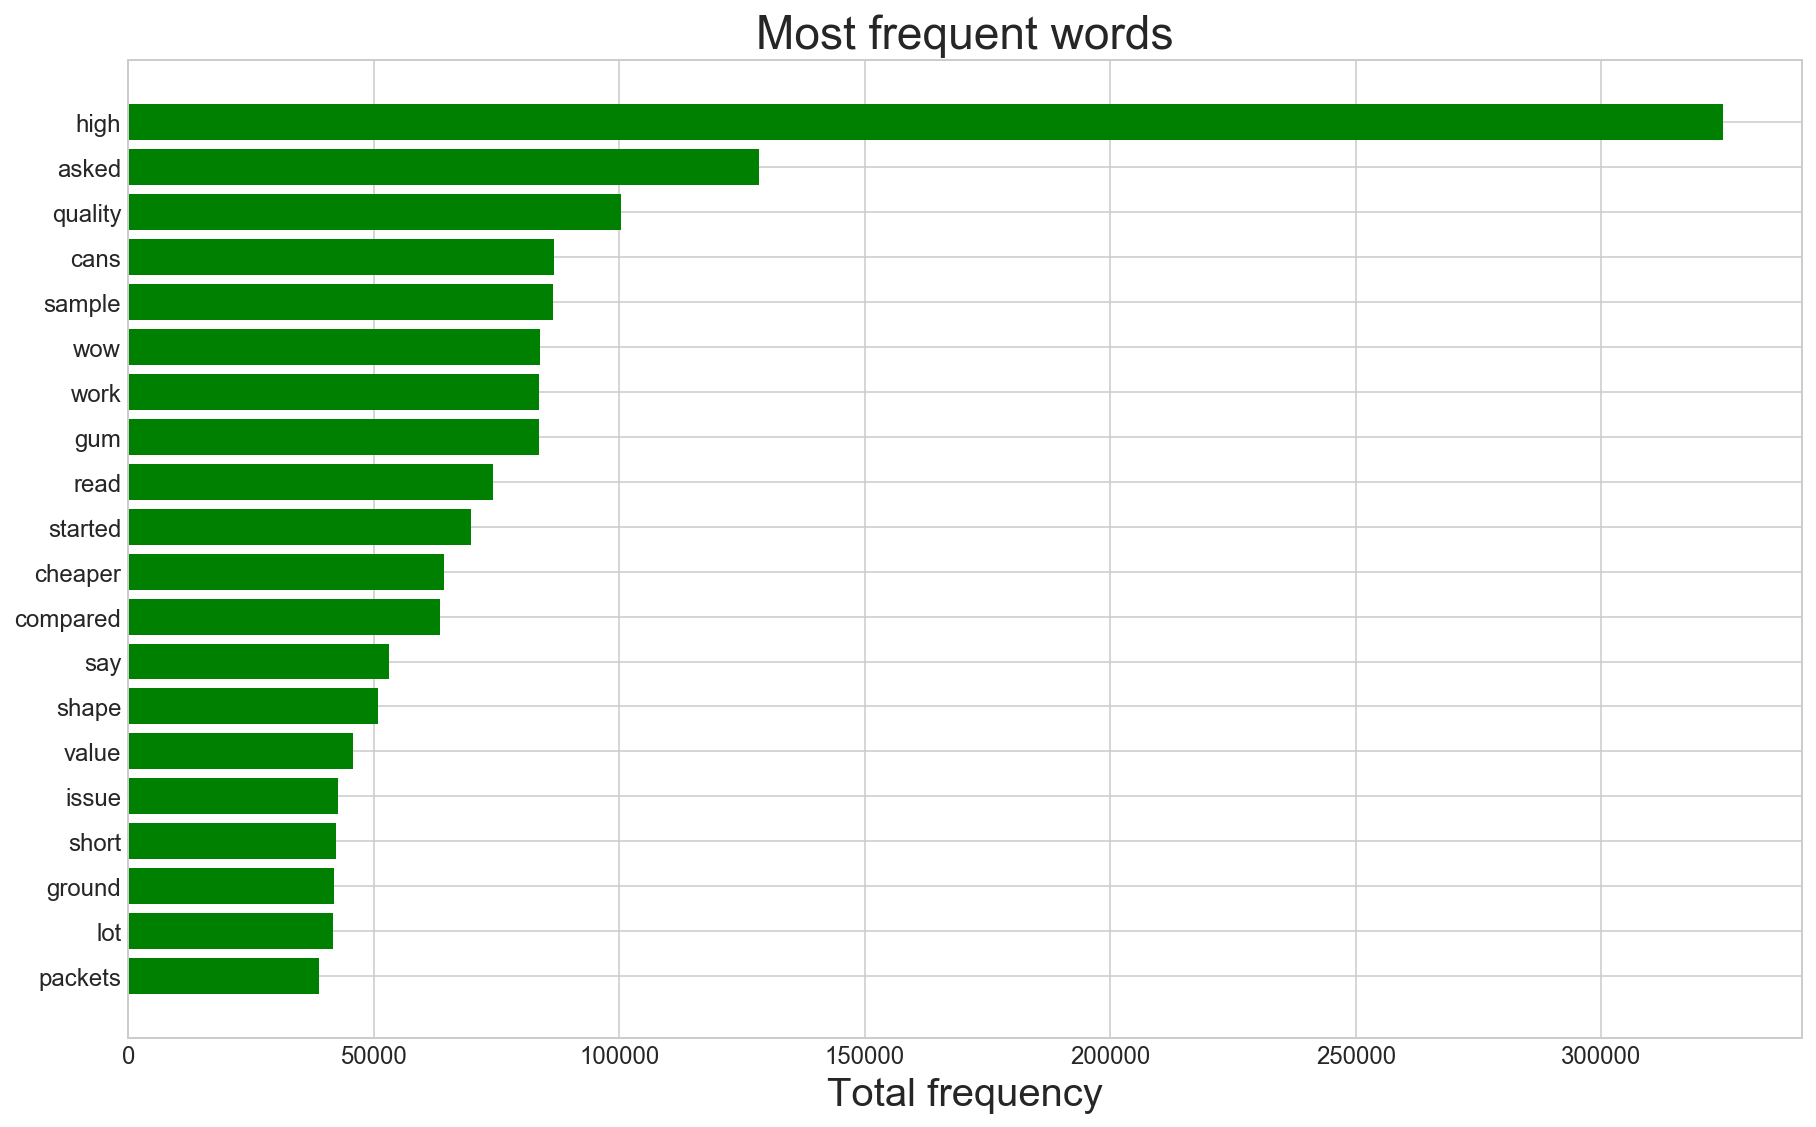

In [68]:
# total_word_frequency has already been sorted
most_frequent_words = total_word_frequency[0:top_x_size]
y_pos = np.arange(top_x_size)

fig, axes = plt.subplots()
axes.barh(y_pos, most_frequent_words, align='center', color='green')

# Most to least frequent
axes.set_yticks(y_pos)
axes.set_yticklabels(most_frequent_words.index)
axes.invert_yaxis()

axes.set_xlabel('Total frequency')

axes.set_title('Most frequent words')

plt.show()

In [69]:
# Accumulate the sum of each of the columns into
words_mean_tf_idf = df_tf_idf.mean(axis = 0).sort_values(ascending=False)

highest_tf_idf = words_mean_tf_idf[0:top_x_size]
y_pos = np.arange(top_x_size)

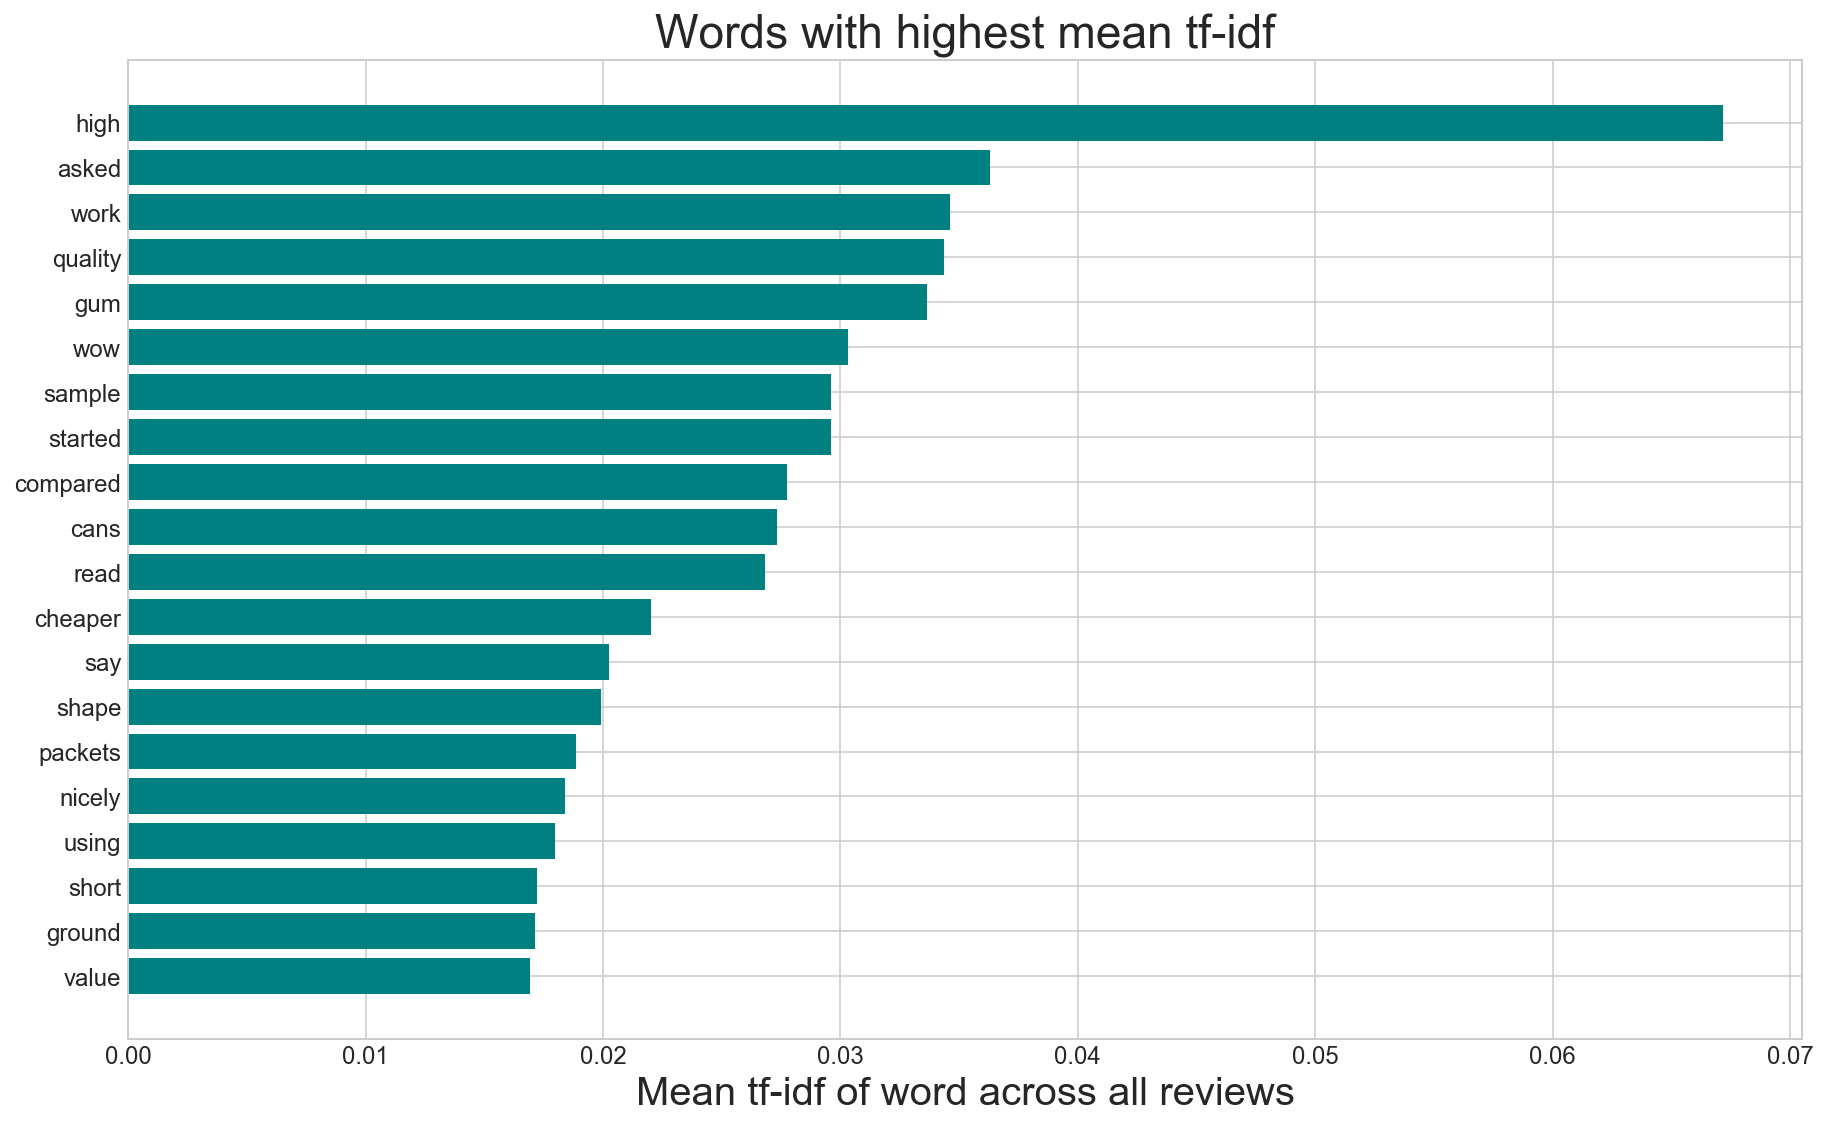

In [74]:
fig, axes = plt.subplots()

axes.barh(y_pos, highest_tf_idf, align='center', color='teal')

axes.set_yticks(y_pos)
axes.set_yticklabels(highest_tf_idf.index)
axes.invert_yaxis()  # labels read top-to-bottom

axes.set_xlabel('Mean tf-idf of word across all reviews')

axes.set_title('Words with highest mean tf-idf')

plt.show()

In [76]:
lowest_tf_idf = words_mean_tf_idf[-1*top_x_size:]
y_pos = np.arange(top_x_size)

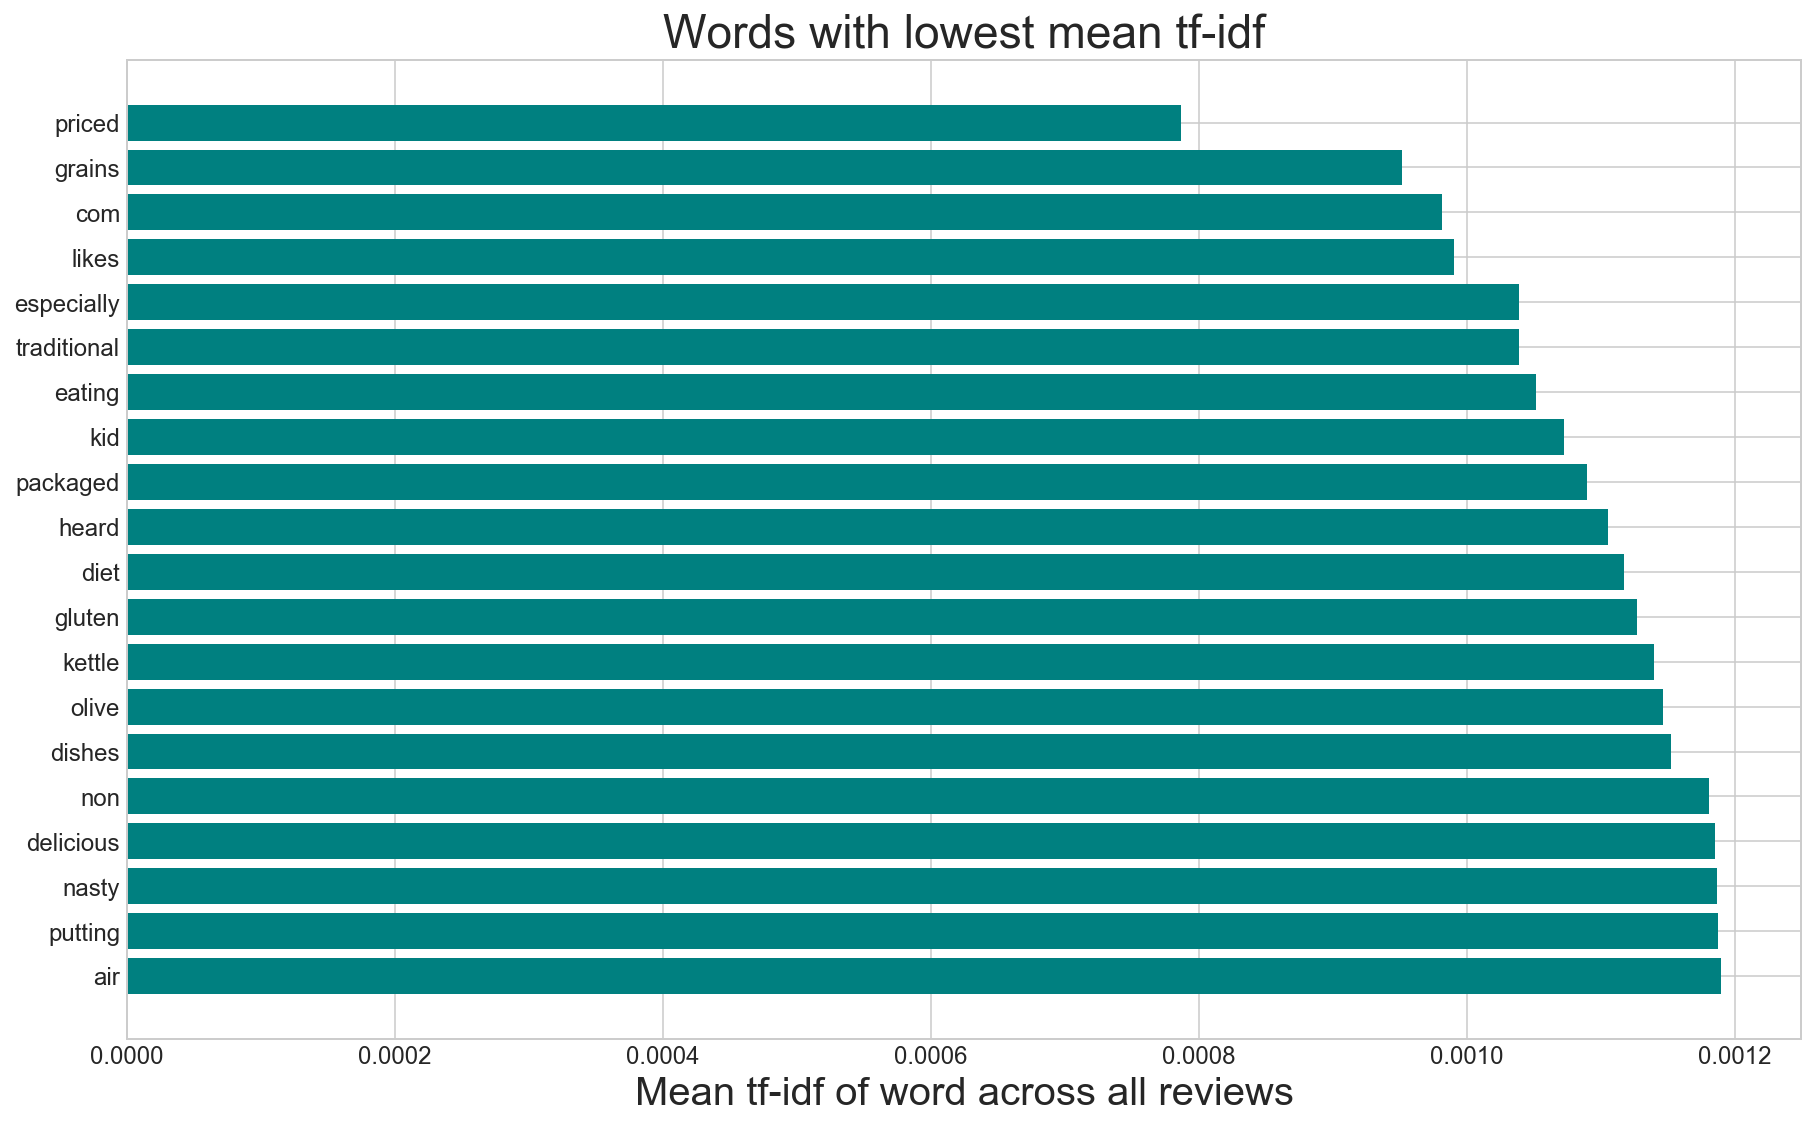

In [77]:
fig, axes = plt.subplots()

axes.barh(y_pos, lowest_tf_idf, align='center', color='teal')
axes.set_yticks(y_pos)
axes.set_yticklabels(lowest_tf_idf.index)
axes.set_xlabel('Mean tf-idf of word across all reviews')

axes.set_title('Words with lowest mean tf-idf')

plt.show()

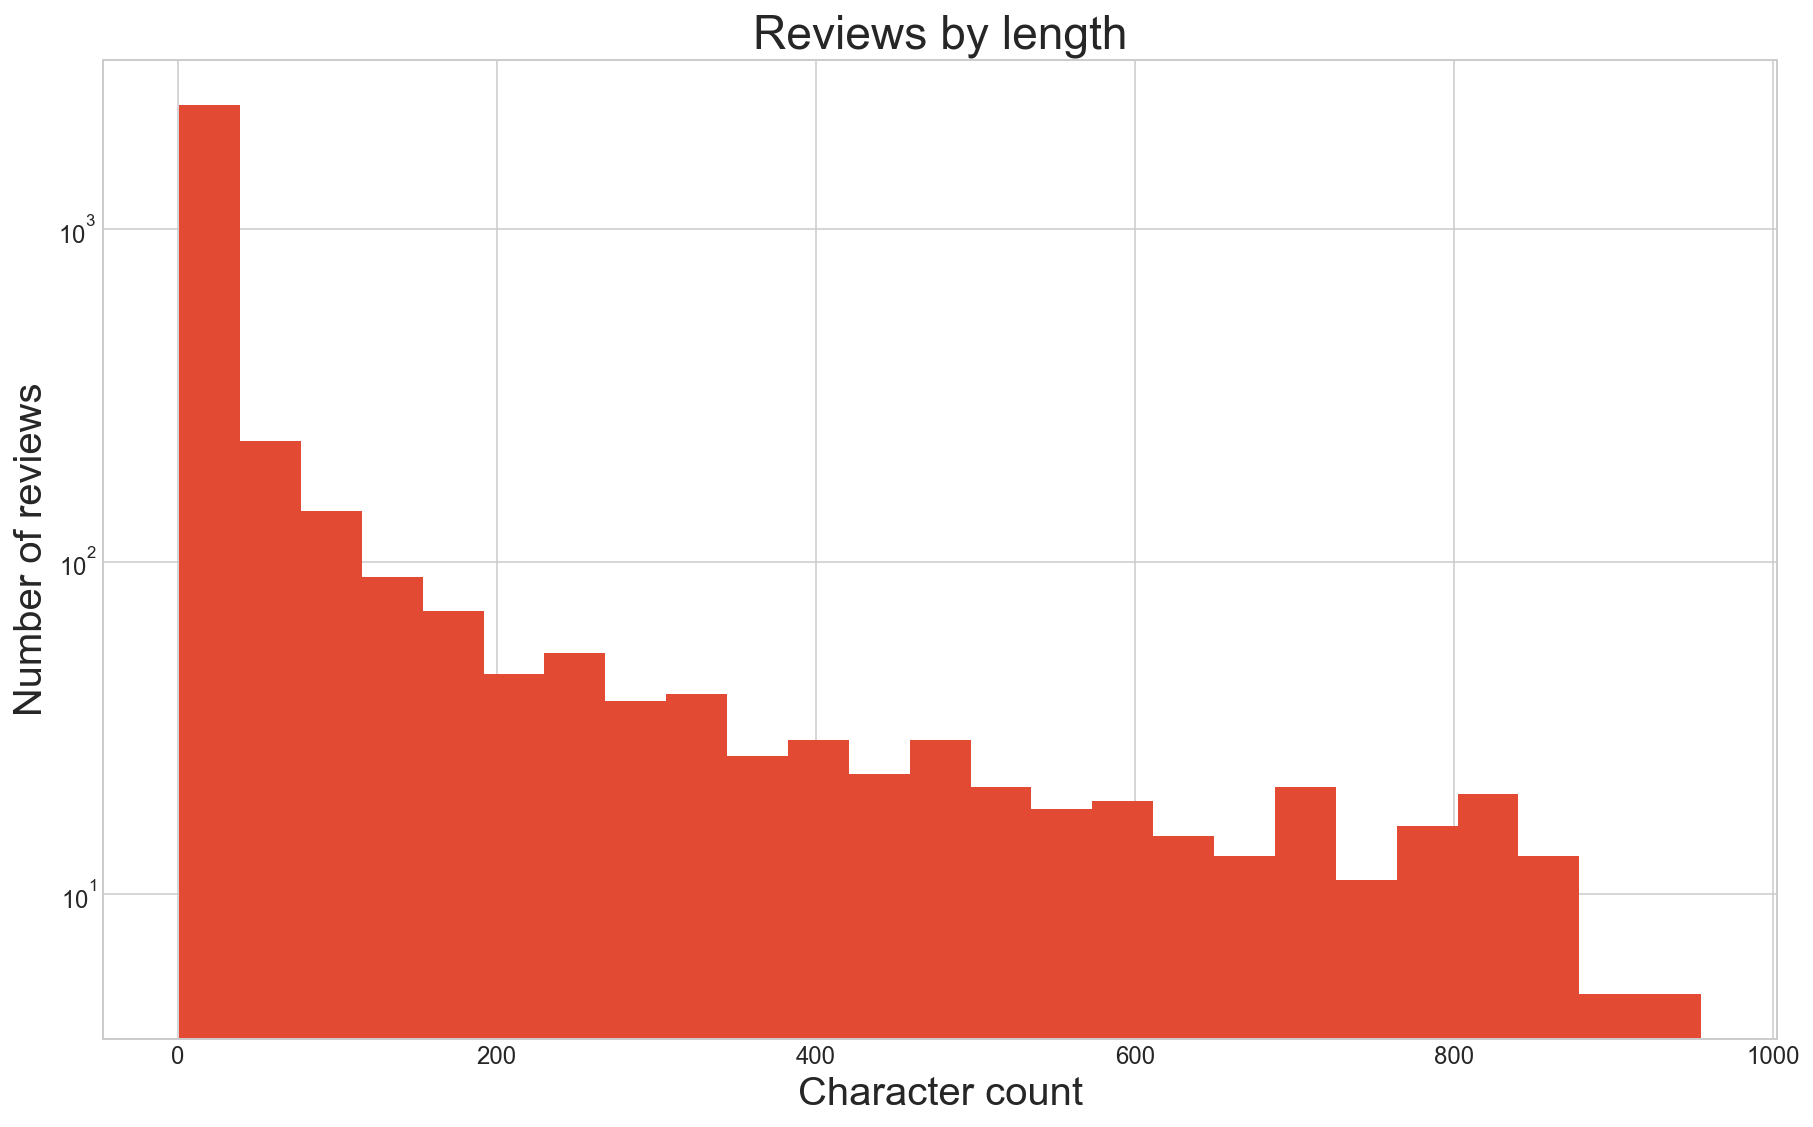

In [78]:
plt.hist(dfs['ReviewLength'].value_counts(), bins=25)
plt.yscale('log')
plt.title('Reviews by length')
plt.ylabel('Number of reviews')
plt.xlabel('Character count')
plt.show()

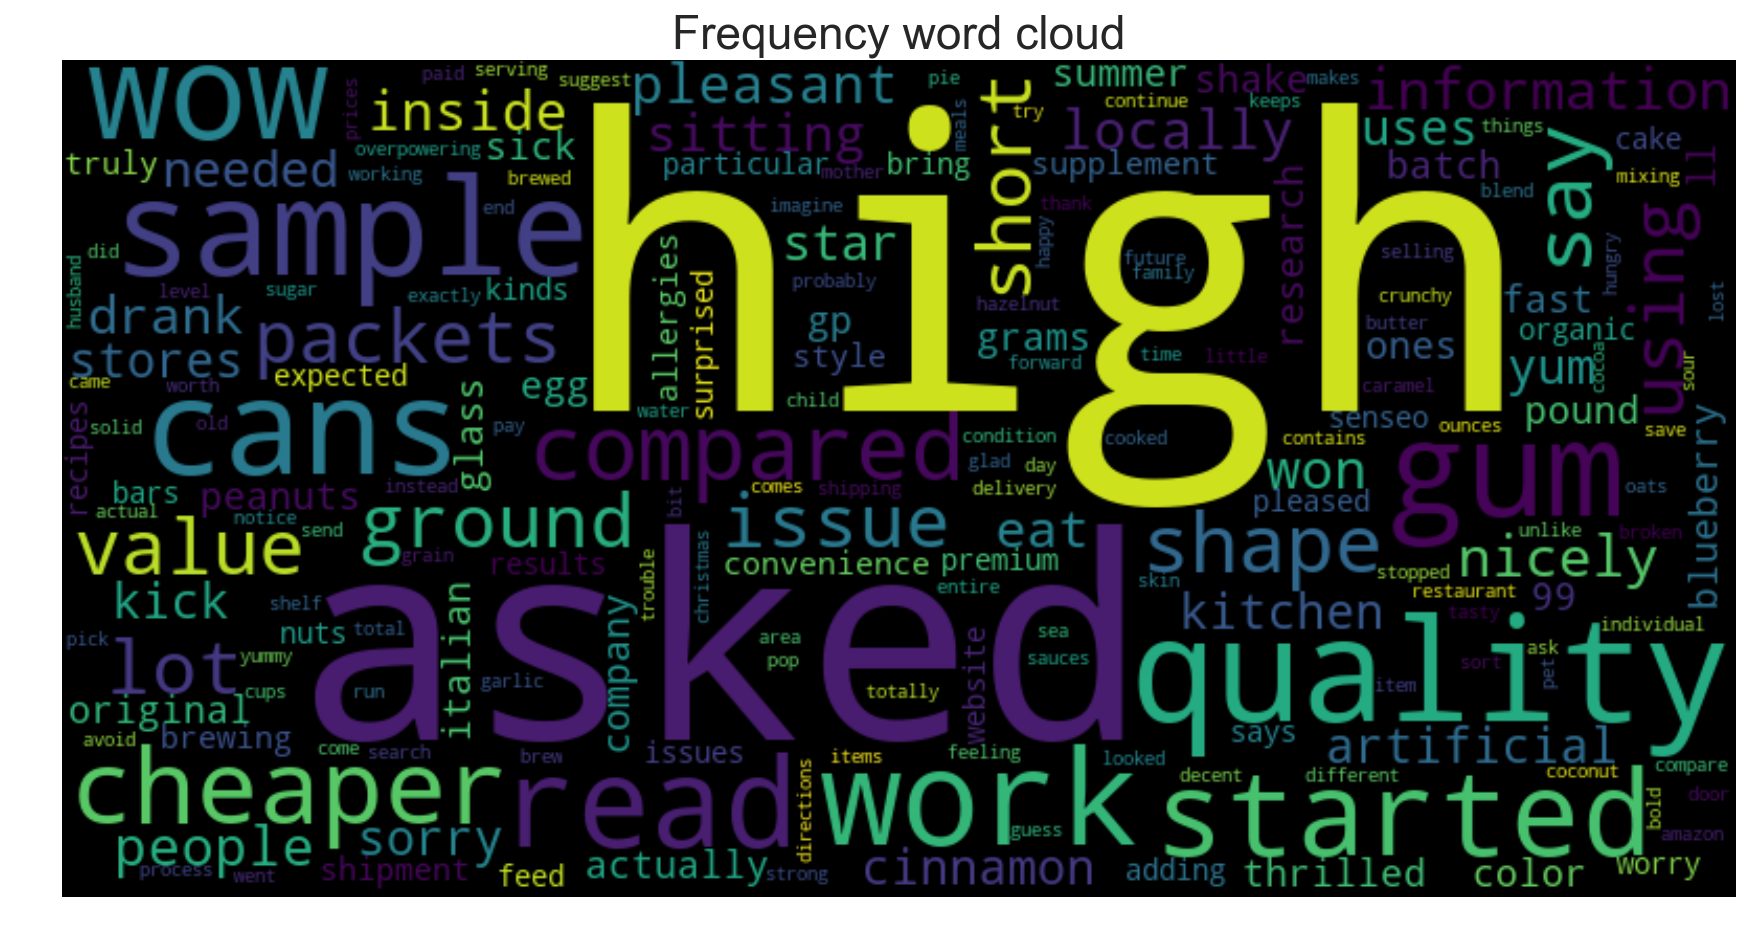

In [82]:
wc = WordCloud(background_color='black',width=800, height=400).generate_from_frequencies(total_word_frequency)
plt.imshow(wc, interpolation='bilinear')
plt.title('Frequency word cloud')
plt.axis("off")
plt.show()

In [83]:
# Full dataset (reviews) grouped by star rating
dfs_split_by_score = {score: dfs[dfs['Score'] == score] for score in range(1,6)}

In [120]:
# Columns are words, rows are reviews, cells are occurrence counts - grouped by star rating
def calculate_word_frequency(field):
    return pd.DataFrame(
        vectorizer.fit_transform(field).toarray(),
        columns=vectorizer.vocabulary_.keys(),
        dtype='int16'
    )

bag_of_words_by_score = {score: calculate_word_frequency(dfs_split_by_score[score]['Text']) for score in range(1,6)}
total_word_frequency_by_score = {key: value.sum(axis=0) for (key, value) in bag_of_words_by_score.items()}

In [121]:
# Columns are words, rows are reviews, cells are word Tf-idf scores - grouped by star rating
def calculate_tf_idf(field):
    return pd.DataFrame(
        tf_idf_vectorizer.fit_transform(field).toarray(),
        columns=tf_idf_vectorizer.vocabulary_.keys(),
        dtype='float32'
    )

tf_idf_split_by_score = {score: calculate_tf_idf(dfs_split_by_score[score]['Text']) for score in range(1,6)}

In [102]:
mean_and_sort = lambda f: f.mean(axis=0).sort_values(ascending=False)
words_mean_tf_idf_split_by_score = {key: mean_and_sort(value) for (key, value) in tf_idf_split_by_score.items()}

In [127]:
def highest_mean_tf_idf_for_score(score):
    words_highest_mean_tf_idf_for_score = words_mean_tf_idf_split_by_score[score][0:top_x_size]
    y_pos = np.arange(top_x_size)
    
    fig, axes = plt.subplots()
    axes.barh(y_pos, words_highest_mean_tf_idf_for_score, align='center', color='green')
    
    axes.set_yticks(y_pos)
    axes.set_yticklabels(words_highest_mean_tf_idf_for_score.index)
    axes.invert_yaxis()
    
    axes.set_xlabel(f'Mean tf-idf of word for all {score}-star reviews')
    axes.set_title(f'Words with highest mean tf-idf among {score}-star reviews')
    plt.show()

def word_cloud_for_score(score):
    masks = {score: f'img/{score}.png' for score in range(1,6)}
    cloud_mask = np.array(Image.open(masks[score]))
    wc = WordCloud(width=800,height=400,mask=cloud_mask)
        .generate_from_frequencies(total_word_frequency_by_score[score])
    
    plt.imshow(wc, interpolation='bilinear')
    plt.title('Most common words for 1 star reviews')
    plt.axis('off')
    plt.show()

IndentationError: unexpected indent (<ipython-input-127-6a69958dafd6>, line 20)

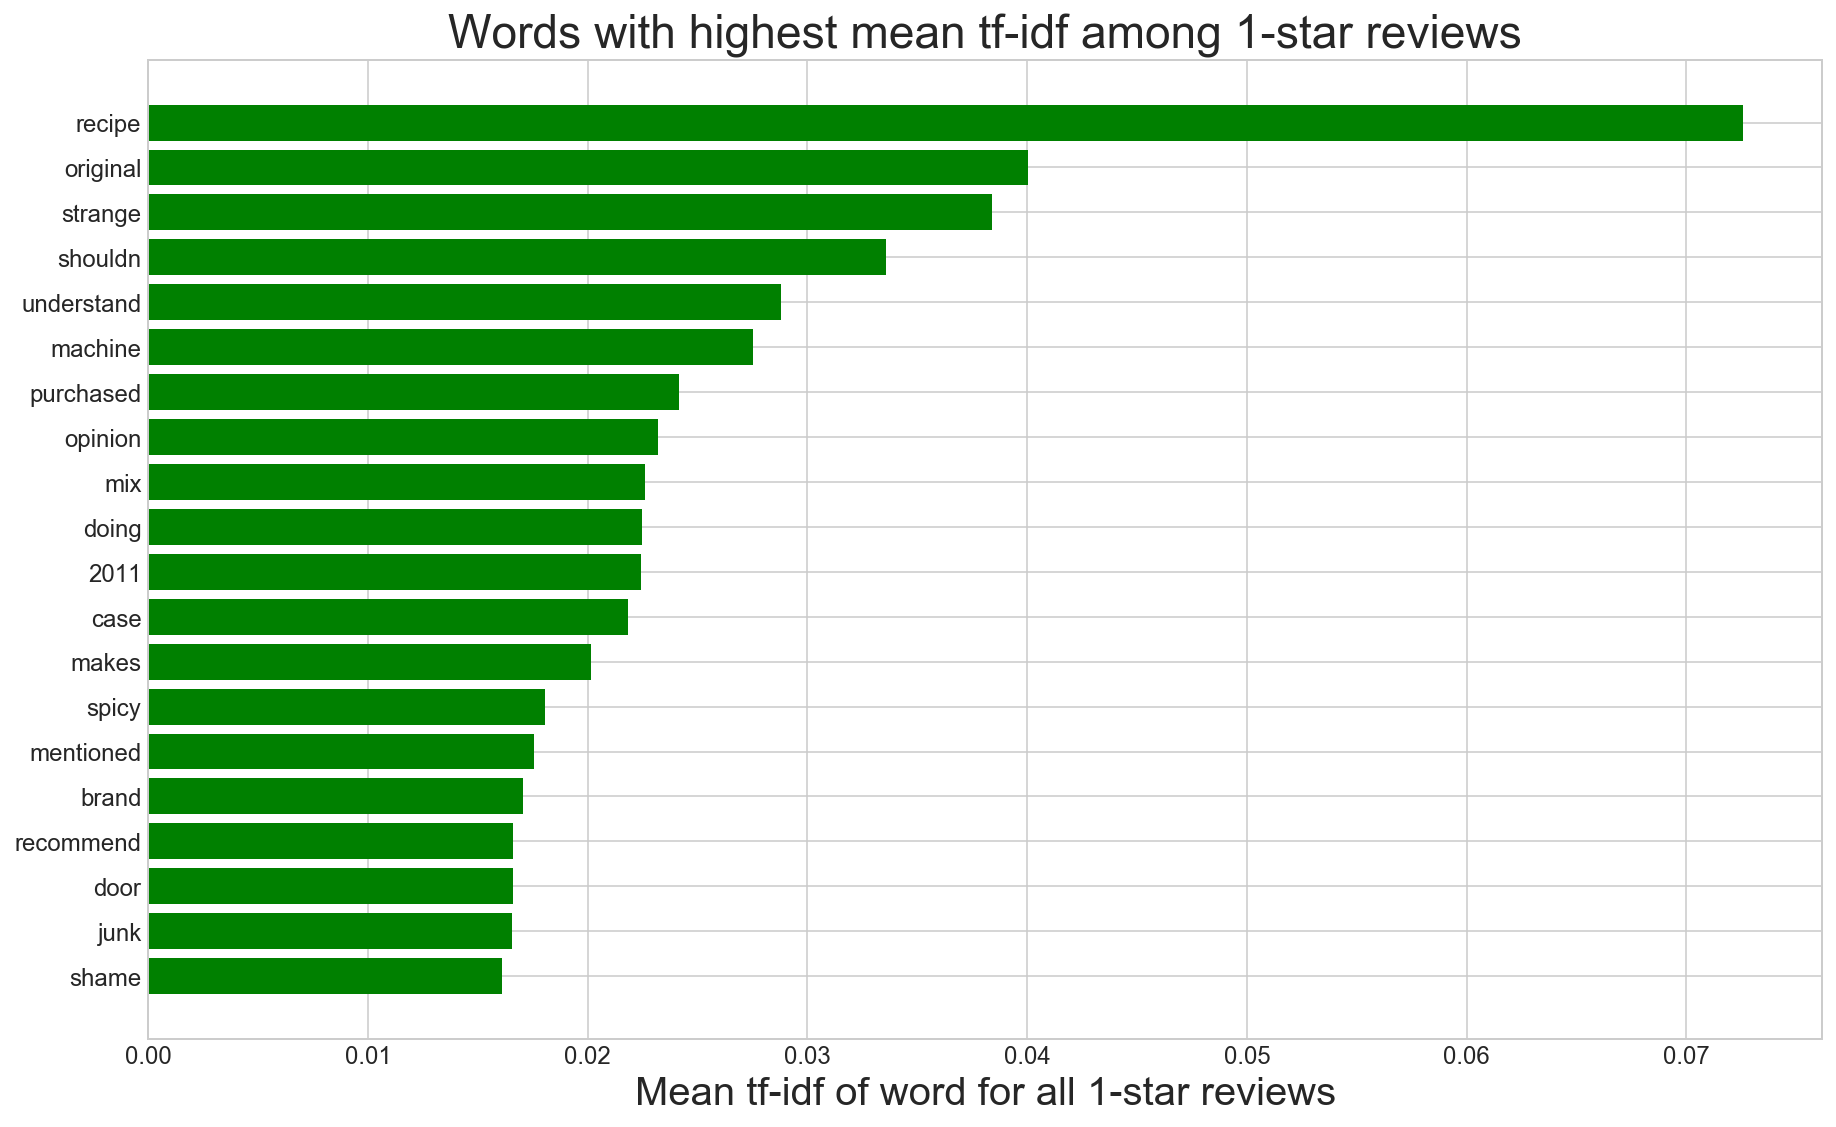

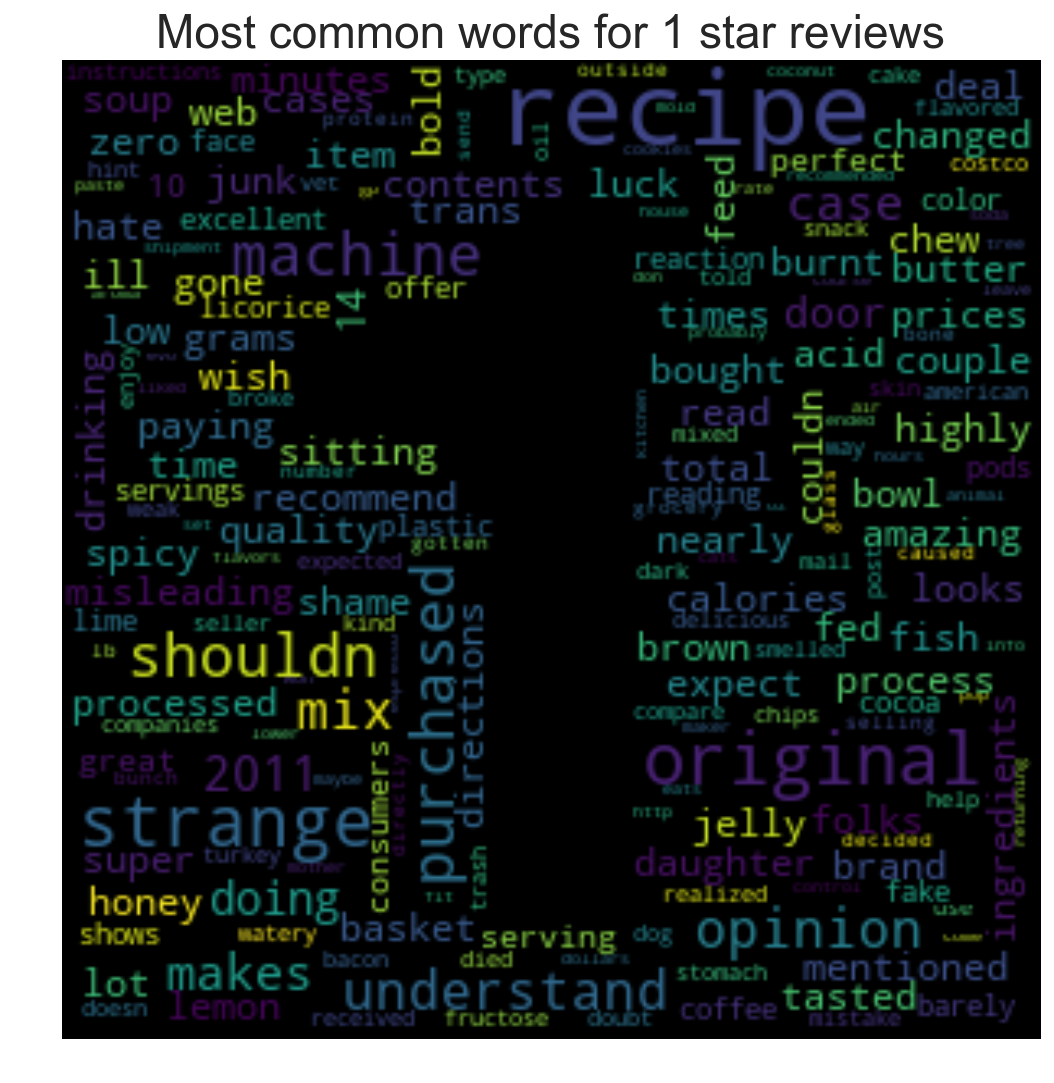

In [128]:
highest_mean_tf_idf_for_score(1)
word_cloud_for_score(1)

In [ ]:
twoStar20RelevantWords = reviewTfidfScoredMean[2][0:20]
y_pos = np.arange(len(oneStar20RelevantWords))

fig, ax = plt.subplots()

ax.barh(y_pos, twoStar20RelevantWords, align='center',
        color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(twoStar20RelevantWords.index)
ax.invert_yaxis()
ax.set_xlabel('Tf/Idf')

ax.set_title('Top most relevant words for 2 star reviews')

plt.show()

In [ ]:
two_mask = np.array(Image.open("img/2.png"))

wc = WordCloud(background_color="white", 
               mask=two_mask).generate_from_frequencies(reviewSumWordsScored[2].sum(axis = 0))
plt.imshow(wc, interpolation='bilinear')
plt.title('Most common words for 2 star reviews')
plt.axis("off")
plt.show()

In [ ]:
threeStar20RelevantWords = reviewTfidfScoredMean[3][0:20]
y_pos = np.arange(len(oneStar20RelevantWords))
wc = WordCloud().generate_from_frequencies(reviewSumWordsScored[1].sum(axis = 0))
plt.imshow(wc, interpolation='bilinear')
plt.title('Most common words for 1 star reviews')
plt.axis("off")
plt.show()
fig, ax = plt.subplots()

ax.barh(y_pos, threeStar20RelevantWords, align='center',
        color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(threeStar20RelevantWords.index)
ax.invert_yaxis()
ax.set_xlabel('Tf/Idf')

ax.set_title('Top most relevant words for 3 star reviews')

plt.show()

In [ ]:
three_mask = np.array(Image.open("img/3.png"))

wc = WordCloud(background_color="white", 
               mask=three_mask).generate_from_frequencies(reviewSumWordsScored[3].sum(axis = 0))
plt.imshow(wc, interpolation='bilinear')
plt.title('Most common words for 3 star reviews')
plt.axis("off")
plt.show()

In [ ]:
fourStar20RelevantWords = reviewTfidfScoredMean[4][0:20]
y_pos = np.arange(len(oneStar20RelevantWords))

fig, ax = plt.subplots()

ax.barh(y_pos, fourStar20RelevantWords, align='center',
        color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(fourStar20RelevantWords.index)
ax.invert_yaxis()
ax.set_xlabel('Tf/Idf')

ax.set_title('Top most relevant words for 4 star reviews')

plt.show()

In [ ]:
four_mask = np.array(Image.open("img/4.png"))

wc = WordCloud(background_color="white", 
               mask=four_mask).generate_from_frequencies(reviewSumWordsScored[4].sum(axis = 0))
plt.imshow(wc, interpolation='bilinear')
plt.title('Most common words for 4 star reviews')
plt.axis("off")
plt.show()

In [ ]:
fiveStar20RelevantWords = reviewTfidfScoredMean[5][0:20]
y_pos = np.arange(len(oneStar20RelevantWords))

fig, ax = plt.subplots()

ax.barh(y_pos, fiveStar20RelevantWords, align='center',
        color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(fiveStar20RelevantWords.index)
ax.invert_yaxis()
ax.set_xlabel('Tf/Idf')

ax.set_title('Top most relevant words for 5 star reviews')

plt.show()

In [ ]:
five_mask = np.array(Image.open("img/5.png"))

wc = WordCloud(background_color="white", 
               mask=five_mask).generate_from_frequencies(reviewSumWordsScored[5].sum(axis = 0))
plt.imshow(wc, interpolation='bilinear')
plt.title('Most common words for 5 star reviews')
plt.axis("off")
plt.show()

In [ ]:
#TODO (PAUL!!!)
# For each target class, visualize the most common relevant words and word frequencies. 
#  Are there any prevalent differences between your target classes? 
#  If you have many target classes, choose a representative subset of classes to perform this visualization. 